In [39]:
import pandas as pd
import gdown
import zipfile
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

In [40]:
# File URL and extraction
file_url = "https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO"
output_zip = "spam.zip"
gdown.download(file_url, output_zip, quiet=False)

with zipfile.ZipFile(output_zip, 'r') as zip_ref:
    zip_ref.extractall("spam_files")
os.remove(output_zip)

# Load dataset
df = pd.read_csv('spam_files/url_spam_classification.csv')

Downloading...
From: https://drive.google.com/uc?id=12MfYQpBl_79ak9K7VHx4jDEaeFUEhHEO
To: /content/spam.zip
100%|██████████| 3.58M/3.58M [00:00<00:00, 12.4MB/s]


In [41]:
# Convert is_spam to binary
df['is_spam'] = df['is_spam'].apply(lambda x: 1 if x == df['is_spam'].unique()[0] else 0)

# Feature extraction
df['len_url'] = df['url'].apply(lambda x: len(x))
df['contains_subscribe'] = df['url'].apply(lambda x: 1 if "subscribe" in x else 0)
df['contains_hash'] = df['url'].apply(lambda x: 1 if "#" in x else 0)
df['num_digits'] = df['url'].apply(lambda x: len("".join(_ for _ in x if _.isdigit())))
df['non_https'] = df['url'].apply(lambda x: 1 if "https" not in x else 0)  # Change to 'non_https'
df['num_words'] = df['url'].apply(lambda x: len(x.split("/")))
df['contains_http'] = df['url'].apply(lambda x: 1 if "http" in x else 0)
df['contains_special_chars'] = df['url'].apply(lambda x: 1 if any(char in x for char in ["$", "%", "&", "!", "@"]) else 0)
df['subdomain_count'] = df['url'].apply(lambda x: len(x.split(".")) - 2)  # Count subdomains

display(df)

# Select features and target
features = df.drop(columns=['url', 'is_spam'])
target = df['is_spam']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


,url,is_spam,len_url,contains_subscribe,contains_hash,num_digits,non_https,num_words,contains_http,contains_special_chars,subdomain_count
0,https://briefingday.us8.list-manage.com/unsubs...,1,51,1,0,1,0,4,1,0,2
1,https://www.hvper.com/,1,22,0,0,0,0,4,1,0,1
2,https://briefingday.com/m/v4n3i4f3,1,34,0,0,4,0,5,1,0,0
3,https://briefingday.com/n/20200618/m#commentform,0,48,0,1,8,0,6,1,0,0
4,https://briefingday.com/fan,1,27,0,0,0,0,4,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...
148298,"https://cdn.substack.com/image/fetch/f_auto,q_...",1,223,0,0,52,0,7,1,1,5
148299,https://numlock.substack.com/subscribe,1,38,1,0,0,0,4,1,0,1
148300,https://docs.google.com/forms/d/e/1FAIpQLSfDLO...,1,99,0,0,11,0,8,1,0,1
148301,https://bookclub.substack.com/,1,30,0,0,0,0,4,1,0,1


In [42]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

In [43]:
# model = Sequential([
#     Dense(128, activation='relu', input_dim=X_train.shape[1]),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(64, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(32, activation='relu'),
#     BatchNormalization(),
#     Dropout(0.5),
#     Dense(1, activation='sigmoid')
# ])

In [44]:
from tensorflow.keras.models import Sequential # Import Sequential from Keras
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout

from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# Apply SMOTE for class imbalance
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_scaled, target)

# Split the resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Modify the ANN architecture
model = Sequential([
    Dense(256, activation='relu', input_dim=X_train.shape[1]),  # Increase neurons
    BatchNormalization(),
    Dropout(0.4),  # Adjust dropout rate
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

# Compile and train the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)  # Increase epochs

# Evaluate the model (same as before)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


4041/4041 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - accuracy: 0.7731 - loss: 0.4969 - val_accuracy: 0.8090 - val_loss: 0.4239
Epoch 2/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8039 - loss: 0.4410 - val_accuracy: 0.8168 - val_loss: 0.4136
Epoch 3/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 21s 3ms/step - accuracy: 0.8099 - loss: 0.4297 - val_accuracy: 0.8220 - val_loss: 0.4020
Epoch 4/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8133 - loss: 0.4240 - val_accuracy: 0.8322 - val_loss: 0.3951
Epoch 5/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 20s 3ms/step - accuracy: 0.8167 - loss: 0.4151 - val_accuracy: 0.8304 - val_loss: 0.3895
Epoch 6/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8178 - loss: 0.4124 - val_accuracy: 0.8277 - val_loss: 0.3876
Epoch 7/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8195 - loss: 0.4098 - val_accuracy: 0.8282 - val_loss: 0.3812
Epoch 8/100
4041/4041 ━━━━━━━━━━━━━━━━━━━━ 14s 3ms/step - accuracy: 0.8217 - loss: 0.408

In [45]:
# # Compile the model
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# # Train the ANN model
# history = model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2, verbose=1)

In [46]:
# Display model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                      │ (None, 256)                 │           2,560 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 109,829 (429.02 KB)

 Trainable params: 36,353 (142.00 KB)

 Non-trainable params: 768 (3.00 KB)

 Optimizer params: 72,708 (284.02 KB)

In [47]:
# Evaluate the ANN model

from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Evaluate the ANN model
ann_pred = (model.predict(X_test) > 0.5).astype(int) # Ensure you are predicting on the entire X_test
ann_pred = np.squeeze(ann_pred) # Remove the extra dimension from ann_pred
print("\nArtificial Neural Network Report:")
print(classification_report(y_test, ann_pred, target_names=[f'Class {label}' for label in unique_classes]))
print("Confusion Matrix:")
print(confusion_matrix(y_test, ann_pred))

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step

Artificial Neural Network Report:
              precision    recall  f1-score   support

     Class 0       0.88      0.81      0.85     20185
     Class 1       0.83      0.89      0.86     20224

    accuracy                           0.85     40409
   macro avg       0.85      0.85      0.85     40409
weighted avg       0.85      0.85      0.85     40409

Confusion Matrix:
[[16447  3738]
 [ 2241 17983]]


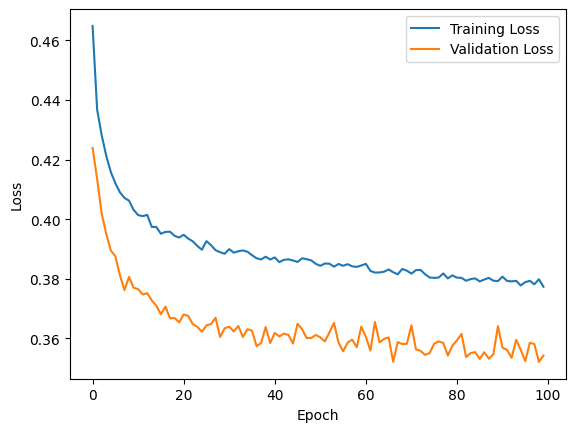

In [48]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay

# Ensure pred is calculated using the entire X_test dataset
pred = (model.predict(X_test) > 0.5).astype(int)
pred = np.squeeze(pred)

accuracy = accuracy_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)
f1 = f1_score(y_test, pred)
roc_auc = roc_auc_score(y_test, pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
print(f"ROC AUC: {roc_auc}")

1263/1263 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
Accuracy: 0.8520379123462595
Precision: 0.8279084756687077
Recall: 0.8891910601265823
F1-Score: 0.8574561926332102
ROC AUC: 0.852002020031089


**Validate the test set**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
              precision    recall  f1-score   support

           0       0.33      0.20      0.25         5
           1       0.50      0.67      0.57         6

    accuracy                           0.45        11
   macro avg       0.42      0.43      0.41        11
weighted avg       0.42      0.45      0.43        11

[[1 4]
 [2 4]]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Prediction Results on New Data:


,Link,Label,Predicted,Prediction Probability
0,https://briefingday.us8.list-manage.com/unsubs,1,1,0.967667
1,https://numlock.substack.com/subscribe,1,1,0.998516
2,https://briefingday.com/n/20200618/m#commentform,0,0,0.031355
3,https://www.youtube.com/,0,1,0.814399
4,https://www.google.com/,0,1,0.811164
5,https://hitha.substack.com/people/976632-hitha...,1,1,0.778560
6,https://us3.campaign-archive.com/,1,1,0.846404
7,"https://cdn.substack.com/image/fetch/f_auto,q_...",1,0,0.459000
8,http://tib.matthewclifford.com/issues/tib-131-...,1,0,0.297445
9,https://web.whatsapp.com/,0,1,0.819715


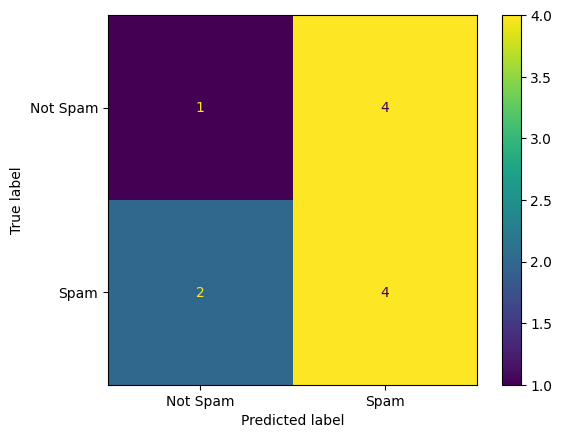

In [52]:
df_test = pd.DataFrame({
    'Link': [
        'https://briefingday.us8.list-manage.com/unsubs',
        'https://numlock.substack.com/subscribe',
        'https://briefingday.com/n/20200618/m#commentform',
        'https://www.youtube.com/',
        'https://www.google.com/',
        'https://hitha.substack.com/people/976632-hitha-palepu',
        'https://us3.campaign-archive.com/',
        'https://cdn.substack.com/image/fetch/f_auto,q_auto:good,fl_progressive:steep/https%3A%2F%2Fbucketeer-e05bbc84-baa3-437e-9518-adb32be77984.s3.amazonaws.com%2Fpublic%2Fimages%2Fcd5914a8-e144-4812-8e41-67e295f05007_150x25.png',
        'http://tib.matthewclifford.com/issues/tib-131-how-smart-are-politicians-why-tech-needs-some-crazy-money-religious-fundamentalism-and-the-internet-and-more-276446',
        'https://web.whatsapp.com/',
        'https://outlook.office365.com/'
    ],
    'Label': [1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0]
})


# Feature extraction
df_test['len_url'] = df_test['Link'].apply(lambda x: len(x))
df_test['contains_subscribe'] = df_test['Link'].apply(lambda x: 1 if "subscribe" in x else 0)
df_test['contains_hash'] = df_test['Link'].apply(lambda x: 1 if "#" in x else 0)
df_test['num_digits'] = df_test['Link'].apply(lambda x: len("".join(_ for _ in x if _.isdigit())))
df_test['non_https'] = df_test['Link'].apply(lambda x: 1 if "https" not in x else 0)
df_test['num_words'] = df_test['Link'].apply(lambda x: len(x.split("/")))
df_test['contains_http'] = df_test['Link'].apply(lambda x: 1 if "http" in x else 0)
df_test['contains_special_chars'] = df_test['Link'].apply(lambda x: 1 if any(char in x for char in ["$", "%", "&", "!", "@"]) else 0)
df_test['subdomain_count'] = df_test['Link'].apply(lambda x: len(x.split(".")) - 2)

# Select features
X_test = df_test.drop(columns=['Link', 'Label'])

# Scale features
X_test_scaled = scaler.transform(X_test)

# Make predictions
pred_test = (model.predict(X_test_scaled) > 0.5).astype(int)


# Evaluate the model
print(classification_report(df_test['Label'], pred_test))
print(confusion_matrix(df_test['Label'], pred_test))


# Make predictions with probabilities
pred_test_probs = model.predict(X_test_scaled)
pred_test = (pred_test_probs > 0.5).astype(int)

# Create a DataFrame for results
results_df = pd.DataFrame({
    'Link': df_test['Link'],
    'Label': df_test['Label'],
    'Predicted': pred_test.flatten(),
    'Prediction Probability': pred_test_probs.flatten()
})

print("Prediction Results on New Data:")
display(results_df)


cm = confusion_matrix(df_test['Label'], pred_test)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Not Spam', 'Spam'])
disp.plot()
plt.show()